### Always to run stuff

In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/amir/projects/frame_stack


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join as jn
import os
import yaml
import torch
# from torchinfo import summary
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset


In [3]:
from video_pipeline.video_module import *

ModuleNotFoundError: No module named 'hdf5plugin'

In [4]:
with open('params.yaml') as conf_file:
    config = yaml.safe_load(conf_file)
with open('pathes.yaml') as conf_file:
    path_config = yaml.safe_load(conf_file)

pressure_path = path_config['p_video_path']
signal_path = path_config['s_video_path']


In [5]:

input_path = path_config['s_video_path']
output_path = path_config['p_video_path']

tr = config['video_train']
frames_number, frames_interval = tr["frames_number"], tr["frames_interval"]

# test_dataset = Stack_dataset(jn(output_path, 'test'), jn(input_path, 'test'), frames_number,
#                              frames_interval)
# train_dataset = Stack_dataset(jn(output_path, 'train'), jn(input_path, 'train'), frames_number,
#                               frames_interval)

def get_elemenst_from_dataset(slice, key_id=10):
    pressure_path, signal_path = jn(output_path, 'test'), jn(input_path, 'test')
    name = "test.hdf5"
    # i = 50

    with h5py.File(jn(signal_path, name)) as signal_file, \
            h5py.File(jn(pressure_path, name)) as pres_file:
            key = list(signal_file.keys())[key_id]
                # for key in tqdm(signal_file.keys(), dynamic_ncols=True, position=1, leave=False):

            signal = (signal_file[key][slice].astype(np.float32))
            pressure = (pres_file[key][slice].astype(np.float32))
    return pressure, signal

In [7]:
import torch_sensor_lib as tsl
sim = tsl.FiberSimulator(config)
# import torch_real_sim_lib as trsl
# new_sim = trsl.FiberSimulator(config)
import torch_bimodal_sim_lib as tbsl
simb = tbsl.FiberSimulator(config)


In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time 

### Клетка для запуска.

## End of always run stuff.
## Beginning of code.

### Загрузка лога хорошего протыкивания

In [9]:
!wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" -O cert.crt -q
import os
import pymongo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


try:
    import dotenv
    dotenv.load_dotenv()
except ImportError:
    pass

client = pymongo.MongoClient(
    host=os.environ['host'],
    port=27018,
    replicaSet='rs01',
    username=os.environ['username'],
    password=os.environ['password'],
    authSource=os.environ['database'],
    tls=True,
    tlsCAFile='cert.crt'
)
db = client[os.environ['database']]

In [10]:
from scipy.interpolate import interp1d

def interplating_parser(target_tenso_signal, subtracting_first=True):
    def log_pars_func(point_res_dict):
        '''Returns signal(target_tenso_signal) value gotten by interpolation'''
        x = np.array(point_res_dict['tenso_signal'])
        y = np.array(point_res_dict['final_power'])
        y = y[x != None]
        x = x[x != None]
        if subtracting_first:
            x = [t - x[0] for t in x]
        x = [float(t) for t in x]
        x = x + np.random.normal(0, 0.0001, len(x))     # чтобы не было совпадений по x
        interpolated_function = interp1d(x, y, kind='linear', fill_value='extrapolate')
        return 1 - interpolated_function(target_tenso_signal)/y[0]
    return log_pars_func
log_pars_func = interplating_parser(15)


In [11]:
# def log_pars_func(point_res_dict):
#     '''Returns max(absolute value) force'''
#     return np.abs(point_res_dict['final_power']).min()
    
def sensor_plotting(points_curves, log_parser_function, vis='hist2d', hist2d_kwargs={}):
    '''Plots 3d or heatmap visualization of spatial characteristics of sensor
    log_parser_function(dict_with_results_in_one_point) -> 1d value to visualize
    example:
    def log_pars_func(point_res_dict):
        """Returns max(absolute value) force"""
        return np.abs(point_res_dict['force_z']).max()
        
    '''
    X = []
    Y = []
    Z = []
    for point_res in points_curves:
        xy = point_res['relative_coordinate']
        X.append(xy[0])
        Y.append(xy[1])
        Z.append(log_parser_function(point_res))
    
    if vis == "scatter":
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
    #     ax.plot_surface(np.array(X).reshape(-1, 1)), np.array(Y).reshape(1, -1), np.array(Z).reshape())
        ax.scatter(np.array(X), np.array(Y), np.array(Z))
        # plt.hexbin(np.array(X), np.array(Y), np.array(Z), gridsize=(10, 2))
    elif vis == 'hist2d':
        xs = set(X)
        ys = set(Y)
        shape = (len(xs), len(ys))
        plt.hist2d(np.array(X), np.array(Y), weights=np.array(Z), bins=shape, **hist2d_kwargs)
        


In [12]:
id = 727
points_curves_1 = db.metrics.find_one({'_id': db.metrics.find_one({'run_id': id, 'name': 'point_results'})['_id']})['values']
points_curves_1 = [point_res for point_res in points_curves_1 if point_res['relative_coordinate'][0] < 16.45]
id = 728
points_curves_2 = db.metrics.find_one({'_id': db.metrics.find_one({'run_id': id, 'name': 'point_results'})['_id']})['values']
points_curves = points_curves_1 + points_curves_2

tenso_target = 10
log_pars_func = interplating_parser(tenso_target, subtracting_first=True)

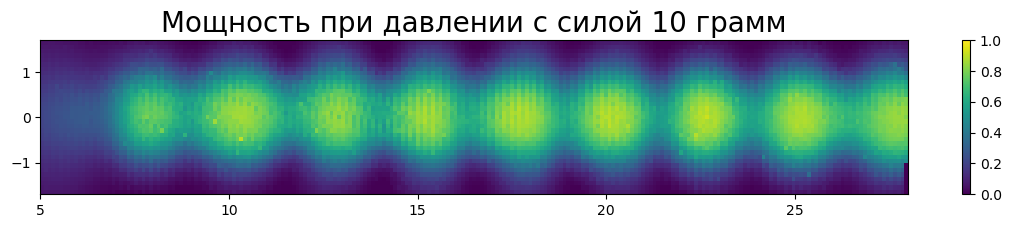

In [13]:

plt.figure(figsize=(14, 2))
sensor_plotting(points_curves, log_pars_func, hist2d_kwargs={"vmin": 0, "vmax": 1} )
plt.colorbar()
plt.title(f"Мощность при давлении с силой {tenso_target} грамм", fontsize=20);

## Установка правильных параметров в конфиг.

In [14]:
config['env']['sen_geometry']['n_angles'] = 1

In [15]:
config['env']['sen_geometry']['distance'] = 0.1
config['env']['phys']['sigma']

1

In [16]:
config['env']['bimodal']['borning_modes'] = [1, 0]
config['env']['bimodal']['impact_modes'] = [1, 1]

In [17]:
config['env']['bimodal']['period'] = 2.5

## Извлекаю экспериментальные зависимости

In [18]:
rel_y = 0.6
filtered_points = [t for t in points_curves if abs(t['relative_coordinate'][1]-rel_y)<0.05]

In [19]:
N = 8

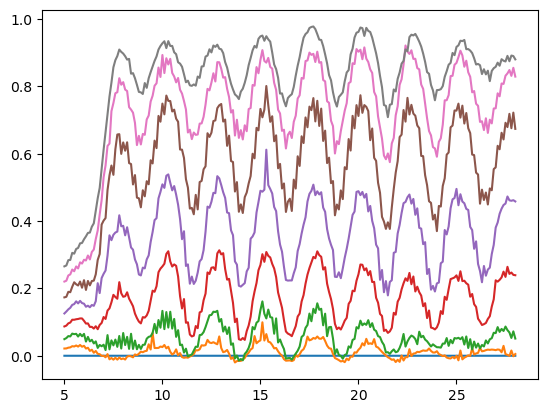

In [20]:
for tenso_target in np.linspace(0, 14, N):
    log_pars_func = interplating_parser(tenso_target, subtracting_first=True)
    Y = []
    signals = []
    for point_res in filtered_points:
        Y.append(point_res['relative_coordinate'][0])
        signals.append(log_pars_func(point_res))
    plt.plot(Y, signals)

In [21]:
sinus_range = [10, 23]

In [22]:
N = 50

In [23]:
exp_forces = np.linspace(0, 14, N)
exp_avg_signal = np.zeros_like(exp_forces)
exp_sinus_ampl = np.zeros_like(exp_forces)

In [24]:

def sinus_func(x, w, phi, A, C):
    return np.sin(x*w + phi)*A + C

from scipy.optimize import curve_fit


for j, tenso_target in enumerate(exp_forces):
    log_pars_func = interplating_parser(tenso_target, subtracting_first=True)

    X = []
    Y = []
    Z = []
    for point_res in filtered_points:
        # xy = point_res['target_coordinate']
        xy = point_res['relative_coordinate']
        if xy[0] < sinus_range[0] or xy[0] > sinus_range[1]:
            continue
        X.append(xy[0])
        Y.append(xy[1])
        Z.append(max(0, min(log_pars_func(point_res), 1)))
        
    popt, pcov = curve_fit(sinus_func, np.array(X), np.array(Z), p0=[2*np.pi/(7/3), 2.5, 0.1, np.mean(Z)])
    exp_sinus_ampl[j] = np.abs(popt[2])
    exp_avg_signal[j] = popt[3]

    
#     plt.plot(X, Z, 'o', ms=2, linewidth=0.5, label=f'F = {tenso_target:.3f}, T={2*np.pi/popt[0]:.3f} мм')  #  +- {np.sqrt(pcov[0, 0]):.3f}
#     t_x = np.linspace(min(X), max(X), 150)
#     plt.plot(t_x, sinus_func(t_x, *popt))
#     plt.xlabel('x, мм')
    
# plt.legend(fontsize=5)

Text(0.5, 1.0, 'Зависимость эффекта от сигнала')

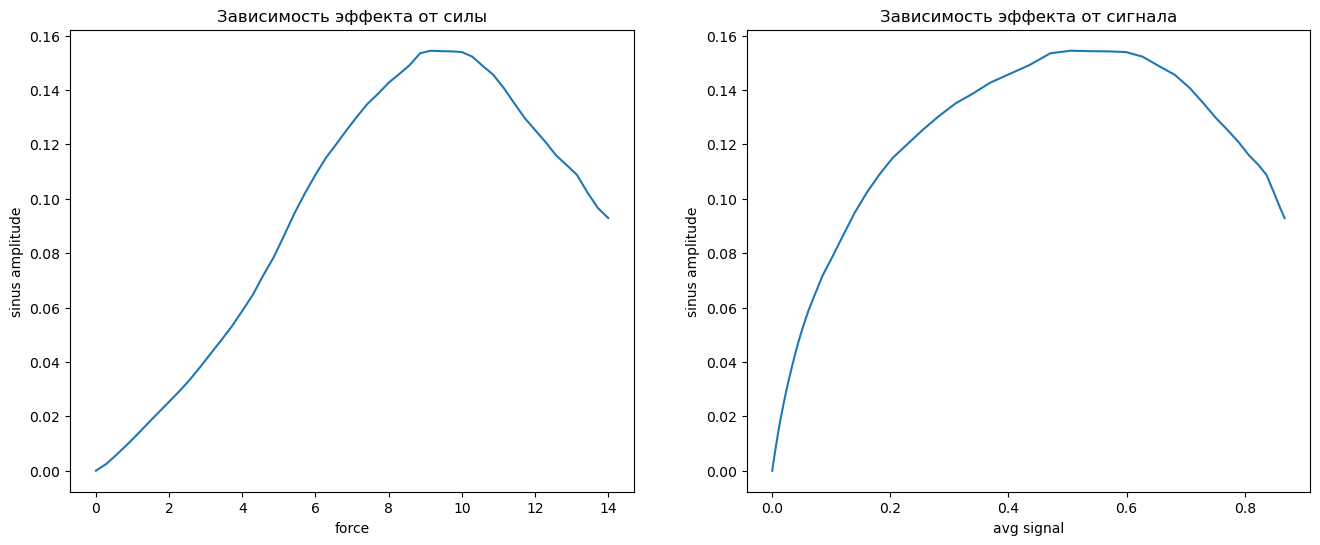

In [25]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(exp_forces, exp_sinus_ampl)
plt.xlabel("force")
plt.ylabel("sinus amplitude")
plt.title("Зависимость эффекта от силы")

plt.subplot(1, 2, 2)
plt.plot(exp_avg_signal, exp_sinus_ampl)
plt.xlabel("avg signal")
plt.ylabel("sinus amplitude")
plt.title("Зависимость эффекта от сигнала")


## Готовлю код для симуляции таких зависимостей

#### Сравниваю блюр тонкой и толстой карты с точечным давлением.

(Решаю проблему с нормировкой при гауссовом блюре)

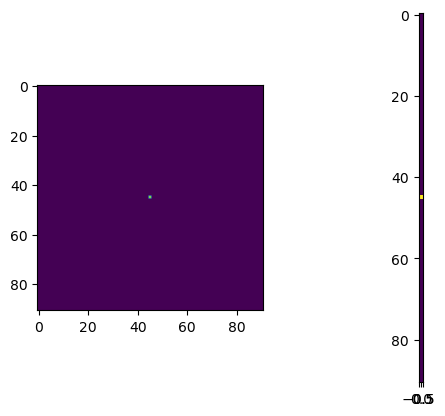

In [52]:
area = np.zeros((91, 91))
line = np.zeros((91, 1))
area[45, 45] = 1
line[45, 0] = 1
plt.subplot(1, 2, 1)
plt.imshow(area)
plt.subplot(1, 2, 2)
plt.imshow(line)

In [54]:
import torch_bimodal_sim_lib as tbsl
simb = tbsl.FiberSimulator(config)
simb.gaus_kernel_size, simb.gaus_sigma_pix

(61, 10.0)

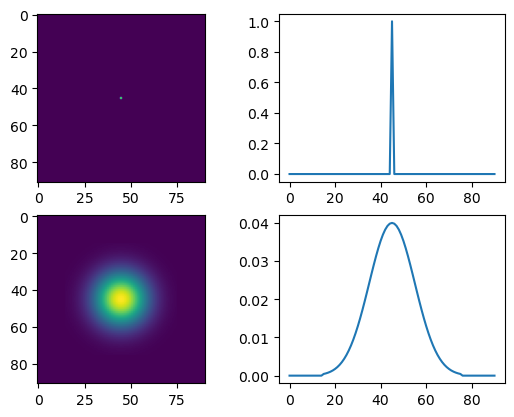

In [61]:
from torchvision.transforms.functional import gaussian_blur

plt.subplot(2, 2, 1)
plt.imshow(area)
plt.subplot(2, 2, 2)
plt.plot(line)
plt.subplot(2, 2, 3)
gaussed_area = gaussian_blur(torch.from_numpy(area[None, ...]), [61, 61], 10)[0]
plt.imshow(gaussed_area)
plt.subplot(2, 2, 4)
gaussed_line = gaussian_blur(torch.from_numpy(line[None, ...]), [1, 61], 10)[0]
plt.plot(gaussed_line)


In [62]:
gaussed_area[45, 45], gaussed_line[45, 0], gaussed_area[45, 45]/gaussed_line[45, 0]

(tensor(0.0016, dtype=torch.float64),
 tensor(0.0400, dtype=torch.float64),
 tensor(0.0400, dtype=torch.float64))

То есть, чтобы никто не заметил подмены, нужно домножать датасет дополнительно на 0.04

генерирую датасет из точечных давлений

In [106]:
indent = 40

def gen_point_pres(x):
    d = 1
    point_pres = np.zeros((111, d), dtype=np.float32)
    point_pres[x, d//2] = 1*0.04 * 40       # firstly for gaus blur. Secondly for force equality
    return point_pres
point_pres = gen_point_pres(35)

dataset_point_presses = np.zeros((point_pres.shape[0]-2*indent,) + point_pres.shape, dtype=np.float32)
for i in range(indent, point_pres.shape[0]-indent):
    dataset_point_presses[i-indent] = gen_point_pres(i)
dataset_X = np.linspace(0, dataset_point_presses.shape[0]*0.1, dataset_point_presses.shape[0], endpoint=False)

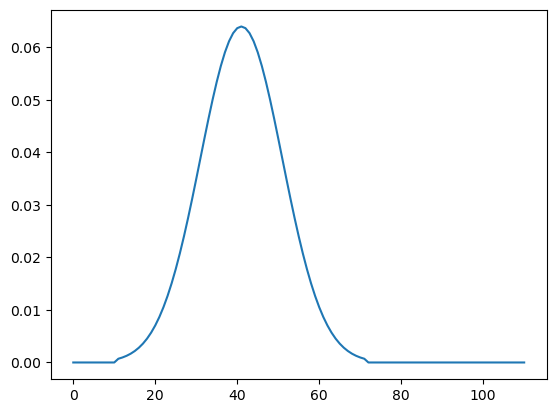

In [107]:
gaussed_line = gaussian_blur(torch.from_numpy(dataset_point_presses[1:2, ...]), [1, 61], 10)[0]
plt.plot(gaussed_line)


### Строю симулированные синусоиды.

In [108]:
N = 10

In [109]:
import torch_bimodal_sim_lib as tbsl
simb = tbsl.FiberSimulator(config)

In [110]:
config['env']['bimodal']['intermode_matrix'] = [[0.5, 0], 
                                                [0.5, 0]]
simb = tbsl.FiberSimulator(config)

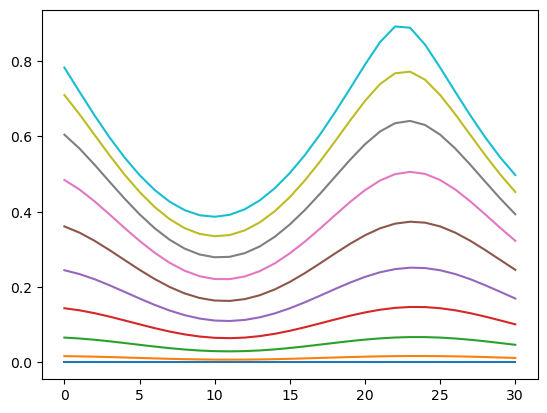

In [111]:
for amplitude in np.linspace(0, 14, N):
    result_numbers = simb.fiber_real_sim(dataset_point_presses*amplitude)
    sinus = result_numbers[:, 0, result_numbers.shape[-1]//2]
    plt.plot(sinus)

## Симулирую необходимые зависимости.

In [113]:
config['env']['bimodal']['intermode_matrix'] = [[0.5, 0], 
                                                [0.5, 0.5]]
simb = tbsl.FiberSimulator(config)

N = len(exp_forces)

forces = np.linspace(0, 14, N)
avg_signal = np.zeros_like(forces)
sinus_ampl = np.zeros_like(forces)


def sinus_func(x, w, phi, A, C):
    return np.sin(x*w + phi)*A + C

from scipy.optimize import curve_fit

for j, ample in enumerate(forces):
    result_numbers = simb.fiber_real_sim(dataset_point_presses*ample)
    sinus = result_numbers[:, 0, result_numbers.shape[-1]//2].numpy()
    
    popt, pcov = curve_fit(sinus_func, dataset_X, sinus, p0=[2*np.pi/(7/3), 2.5, 0.1, np.mean(sinus)])
    sinus_ampl[j] = np.abs(popt[2])
    avg_signal[j] = popt[3]


In [1]:
plt.figure(figsize=(24, 6))

plt.subplot(1, 3, 1)
plt.plot(exp_forces, exp_sinus_ampl)
plt.plot(forces, sinus_ampl)
plt.xlabel("force")
plt.ylabel("sinus amplitude")
plt.title("Зависимость эффекта от силы")

plt.subplot(1, 3, 2)
plt.plot(exp_avg_signal, exp_sinus_ampl)
plt.plot(avg_signal, sinus_ampl)
plt.xlabel("avg signal")
plt.ylabel("sinus amplitude")
plt.title("Зависимость эффекта от сигнала")

plt.subplot(1, 3, 3)
plt.plot(exp_forces, exp_avg_signal)
plt.plot(forces, avg_signal)
plt.xlabel("force")
plt.ylabel("avg signal")
plt.title("Зависимость сигнала от силы")


NameError: name 'plt' is not defined

# По 10 точкам пытаюсь найти хорошие параметры.

In [26]:
N = 10

In [27]:
indent = 40

def gen_point_pres(x):
    d = 1
    point_pres = np.zeros((111, d), dtype=np.float32)
    point_pres[x, d//2] = 1*0.04 * 40       # firstly for gaus blur. Secondly for force equality
    return point_pres
point_pres = gen_point_pres(35)

dataset_point_presses = np.zeros((point_pres.shape[0]-2*indent,) + point_pres.shape, dtype=np.float32)
for i in range(indent, point_pres.shape[0]-indent):
    dataset_point_presses[i-indent] = gen_point_pres(i)
dataset_X = np.linspace(0, dataset_point_presses.shape[0]*0.1, dataset_point_presses.shape[0], endpoint=False)

In [28]:
sinus_range = [10, 23]

In [29]:
exp_forces = np.linspace(0, 14, N)
exp_avg_signal = np.zeros_like(exp_forces)
exp_sinus_ampl = np.zeros_like(exp_forces)

In [30]:

def sinus_func(x, w, phi, A, C):
    return np.sin(x*w + phi)*A + C

from scipy.optimize import curve_fit


for j, tenso_target in enumerate(exp_forces):
    log_pars_func = interplating_parser(tenso_target, subtracting_first=True)

    X = []
    Y = []
    Z = []
    for point_res in filtered_points:
        # xy = point_res['target_coordinate']
        xy = point_res['relative_coordinate']
        if xy[0] < sinus_range[0] or xy[0] > sinus_range[1]:
            continue
        X.append(xy[0])
        Y.append(xy[1])
        Z.append(max(0, min(log_pars_func(point_res), 1)))
        
    popt, pcov = curve_fit(sinus_func, np.array(X), np.array(Z), p0=[2*np.pi/(7/3), 2.5, 0.1, np.mean(Z)])
    exp_sinus_ampl[j] = np.abs(popt[2])
    exp_avg_signal[j] = popt[3]

    
#     plt.plot(X, Z, 'o', ms=2, linewidth=0.5, label=f'F = {tenso_target:.3f}, T={2*np.pi/popt[0]:.3f} мм')  #  +- {np.sqrt(pcov[0, 0]):.3f}
#     t_x = np.linspace(min(X), max(X), 150)
#     plt.plot(t_x, sinus_func(t_x, *popt))
#     plt.xlabel('x, мм')
    
# plt.legend(fontsize=5)

#### Объявление функции симуляции

In [31]:
def simulate_curves(matrix):

    config['env']['bimodal']['intermode_matrix'] = matrix
    
    simb = tbsl.FiberSimulator(config)

    N = len(exp_forces)

    forces = np.linspace(0, 14, N)
    avg_signal = np.zeros_like(forces)
    sinus_ampl = np.zeros_like(forces)


    def sinus_func(x, w, phi, A, C):
        return np.sin(x*w + phi)*A + C

    from scipy.optimize import curve_fit

    for j, ample in enumerate(forces):
        result_numbers = simb.fiber_real_sim(dataset_point_presses*ample)
        sinus = result_numbers[:, 0, result_numbers.shape[-1]//2].numpy()
        
        popt, pcov = curve_fit(sinus_func, dataset_X, sinus, p0=[2*np.pi/(7/3), 2.5, 0.1, np.mean(sinus)])
        sinus_ampl[j] = np.abs(popt[2])
        avg_signal[j] = popt[3]
    
    return forces, avg_signal, sinus_ampl


In [32]:
forces, avg_signal, sinus_ampl = simulate_curves([[0.5, 0], 
                                                [0.5, 0.5]])

Text(0.5, 1.0, 'Зависимость сигнала от силы')

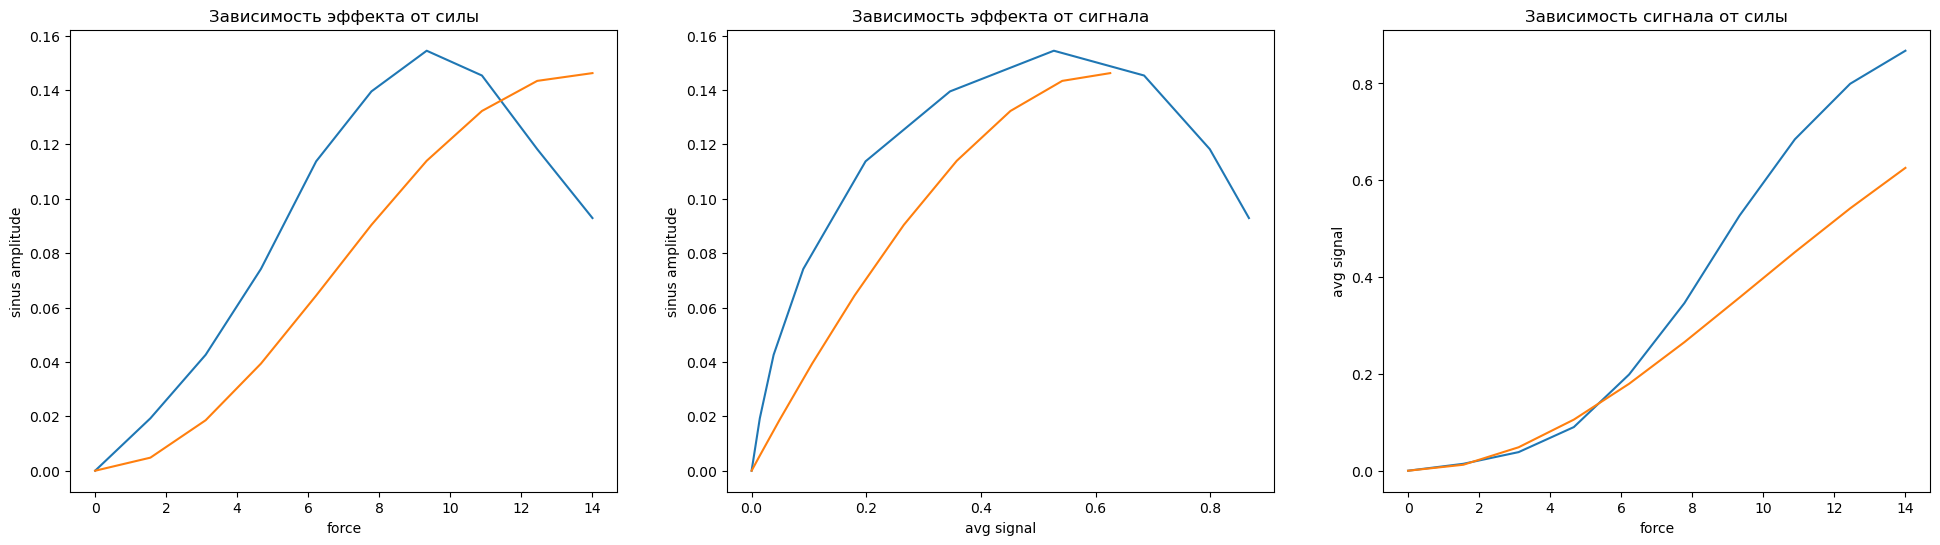

In [33]:
plt.figure(figsize=(24, 6))

plt.subplot(1, 3, 1)
plt.plot(exp_forces, exp_sinus_ampl)
plt.plot(forces, sinus_ampl)
plt.xlabel("force")
plt.ylabel("sinus amplitude")
plt.title("Зависимость эффекта от силы")

plt.subplot(1, 3, 2)
plt.plot(exp_avg_signal, exp_sinus_ampl)
plt.plot(avg_signal, sinus_ampl)
plt.xlabel("avg signal")
plt.ylabel("sinus amplitude")
plt.title("Зависимость эффекта от сигнала")

plt.subplot(1, 3, 3)
plt.plot(exp_forces, exp_avg_signal)
plt.plot(forces, avg_signal)
plt.xlabel("force")
plt.ylabel("avg signal")
plt.title("Зависимость сигнала от силы")


### Запускаю на этом shgo оптимизатор.

In [34]:
def dist_func(params):
    forces, avg_signal, sinus_ampl = simulate_curves([[params[0], params[1]], 
                                                [params[2], params[3]]])
    dist = np.mean(np.square(avg_signal-exp_avg_signal)) + np.mean(np.square(sinus_ampl-exp_sinus_ampl))
    return dist

In [35]:
dist_func([0.5, 0.5, 0.5, 0.5])

0.02788069625669417

In [36]:
from scipy import optimize

res = optimize.shgo(dist_func, [(0, 1), (0, 1), (0, 1), (0, 1)])
res

     fun: 0.0032182389384533346
    funl: array([0.00321824])
 message: 'Optimization terminated successfully.'
    nfev: 56
     nit: 2
   nlfev: 39
   nlhev: 0
   nljev: 5
 success: True
       x: array([8.83458646e-01, 9.15247256e-20, 9.73792396e-01, 9.95924965e-01])
      xl: array([[8.83458646e-01, 9.15247256e-20, 9.73792396e-01, 9.95924965e-01]])

Text(0.5, 1.0, 'Зависимость сигнала от силы')

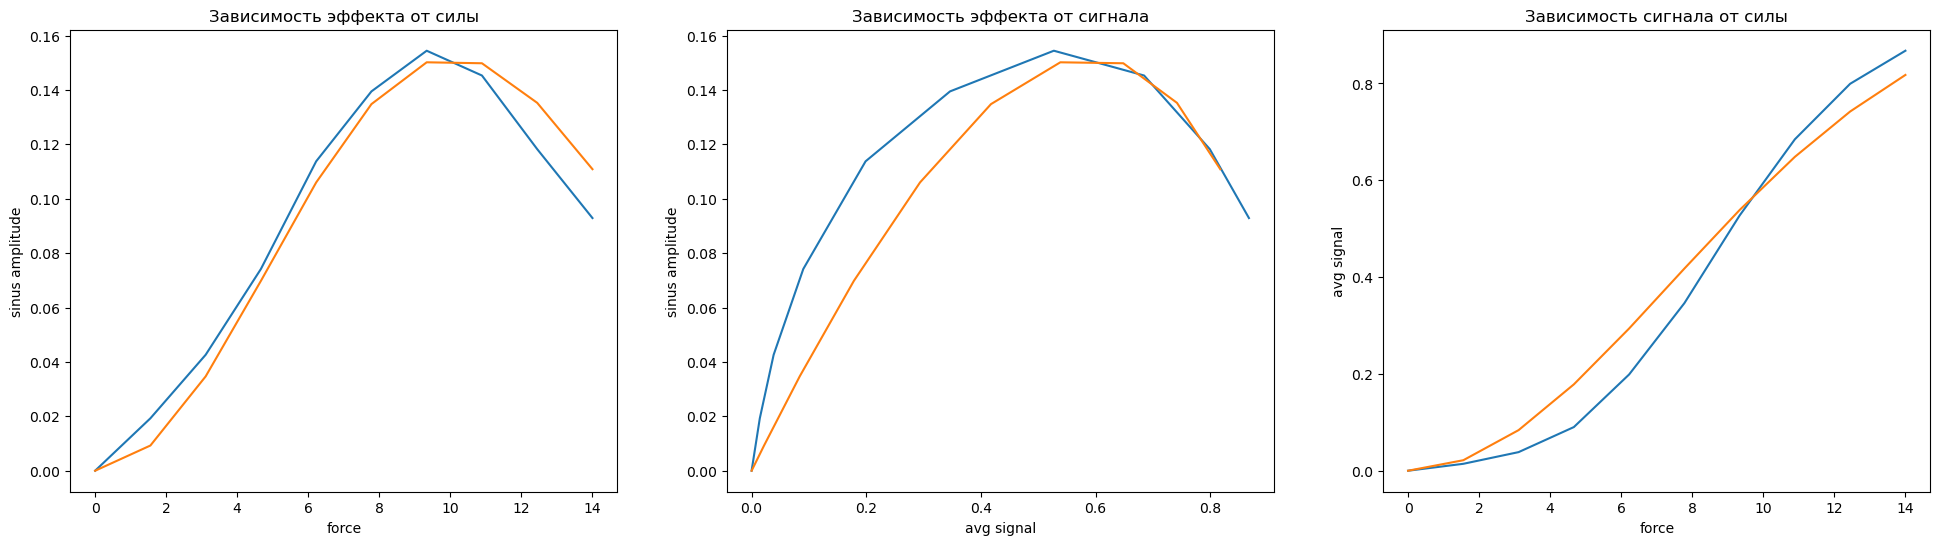

In [ ]:
forces, avg_signal, sinus_ampl = simulate_curves([res.x[0:2], res.x[2:4]])
plt.figure(figsize=(24, 6))

plt.subplot(1, 3, 1)
plt.plot(exp_forces, exp_sinus_ampl)
plt.plot(forces, sinus_ampl)
plt.xlabel("force")
plt.ylabel("sinus amplitude")
plt.title("Зависимость эффекта от силы")

plt.subplot(1, 3, 2)
plt.plot(exp_avg_signal, exp_sinus_ampl)
plt.plot(avg_signal, sinus_ampl)
plt.xlabel("avg signal")
plt.ylabel("sinus amplitude")
plt.title("Зависимость эффекта от сигнала")

plt.subplot(1, 3, 3)
plt.plot(exp_forces, exp_avg_signal)
plt.plot(forces, avg_signal)
plt.xlabel("force")
plt.ylabel("avg signal")
plt.title("Зависимость сигнала от силы")


In [38]:
from scipy import optimize

res = optimize.shgo(dist_func, [(0, 4.0), (-2.0, 3.0), (-2.0, 3.0), (0.0, 4.0)])
res

     fun: 0.027081685383027812
    funl: array([0.02708169, 0.03411584])
 message: 'Optimization terminated successfully.'
    nfev: 27
     nit: 2
   nlfev: 10
   nlhev: 0
   nljev: 2
 success: True
       x: array([ 0.,  3., -2.,  4.])
      xl: array([[ 0.,  3., -2.,  4.],
       [ 0., -2.,  3.,  4.]])

Text(0.5, 1.0, 'Зависимость сигнала от силы')

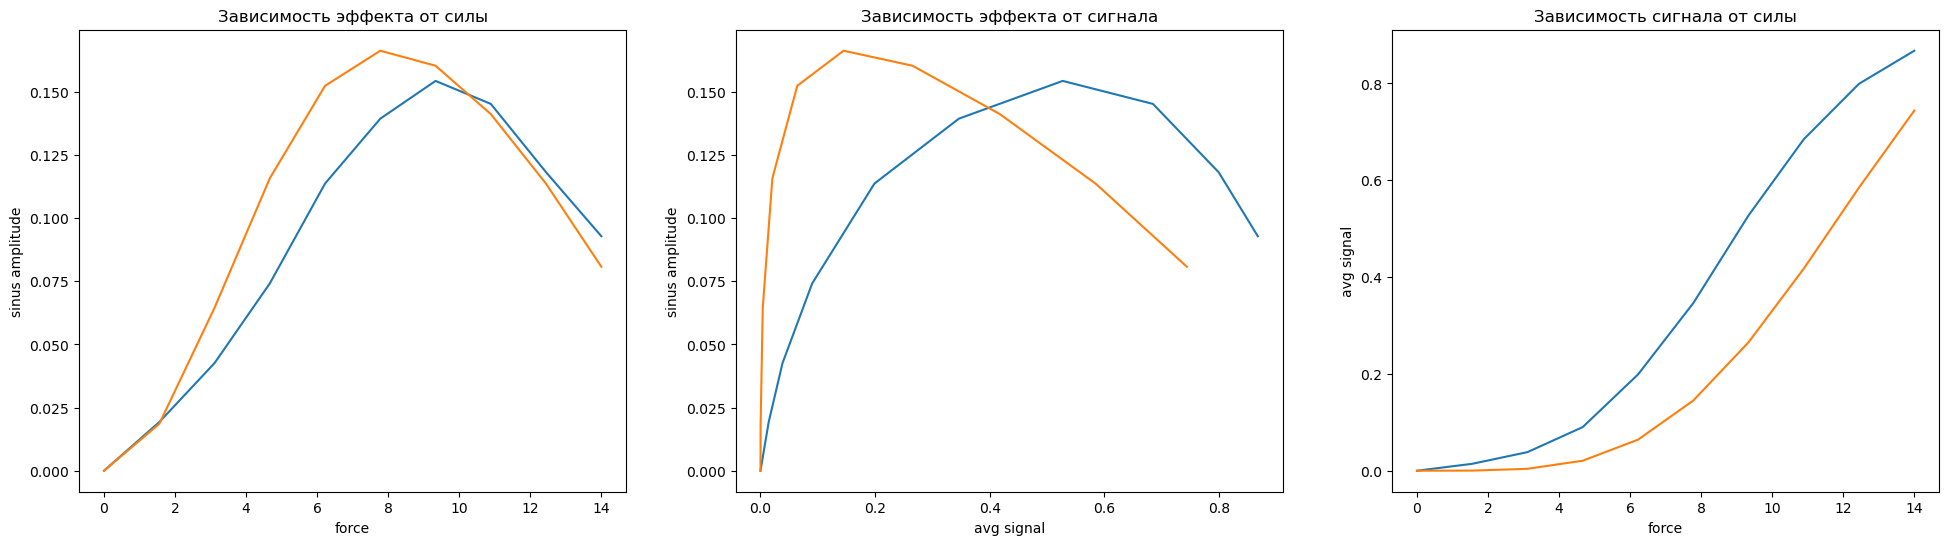

In [39]:
forces, avg_signal, sinus_ampl = simulate_curves([res.x[0:2], res.x[2:4]])
plt.figure(figsize=(24, 6))

plt.subplot(1, 3, 1)
plt.plot(exp_forces, exp_sinus_ampl)
plt.plot(forces, sinus_ampl)
plt.xlabel("force")
plt.ylabel("sinus amplitude")
plt.title("Зависимость эффекта от силы")

plt.subplot(1, 3, 2)
plt.plot(exp_avg_signal, exp_sinus_ampl)
plt.plot(avg_signal, sinus_ampl)
plt.xlabel("avg signal")
plt.ylabel("sinus amplitude")
plt.title("Зависимость эффекта от сигнала")

plt.subplot(1, 3, 3)
plt.plot(exp_forces, exp_avg_signal)
plt.plot(forces, avg_signal)
plt.xlabel("force")
plt.ylabel("avg signal")
plt.title("Зависимость сигнала от силы")


In [44]:
def dist_func2(params):
    forces, avg_signal, sinus_ampl = simulate_curves([[params[0], 0], 
                                                [params[1], params[2]]])
    dist = np.mean(np.square(avg_signal-exp_avg_signal)) + np.mean(np.square(sinus_ampl-exp_sinus_ampl))
    return dist

In [49]:
from scipy import optimize

res = optimize.shgo(dist_func2, [(0, 4), (0, 4), (0, 4)])
res

/home/amir/anaconda3/envs/rqc_env/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0.5, 1.0, 'Зависимость сигнала от силы')

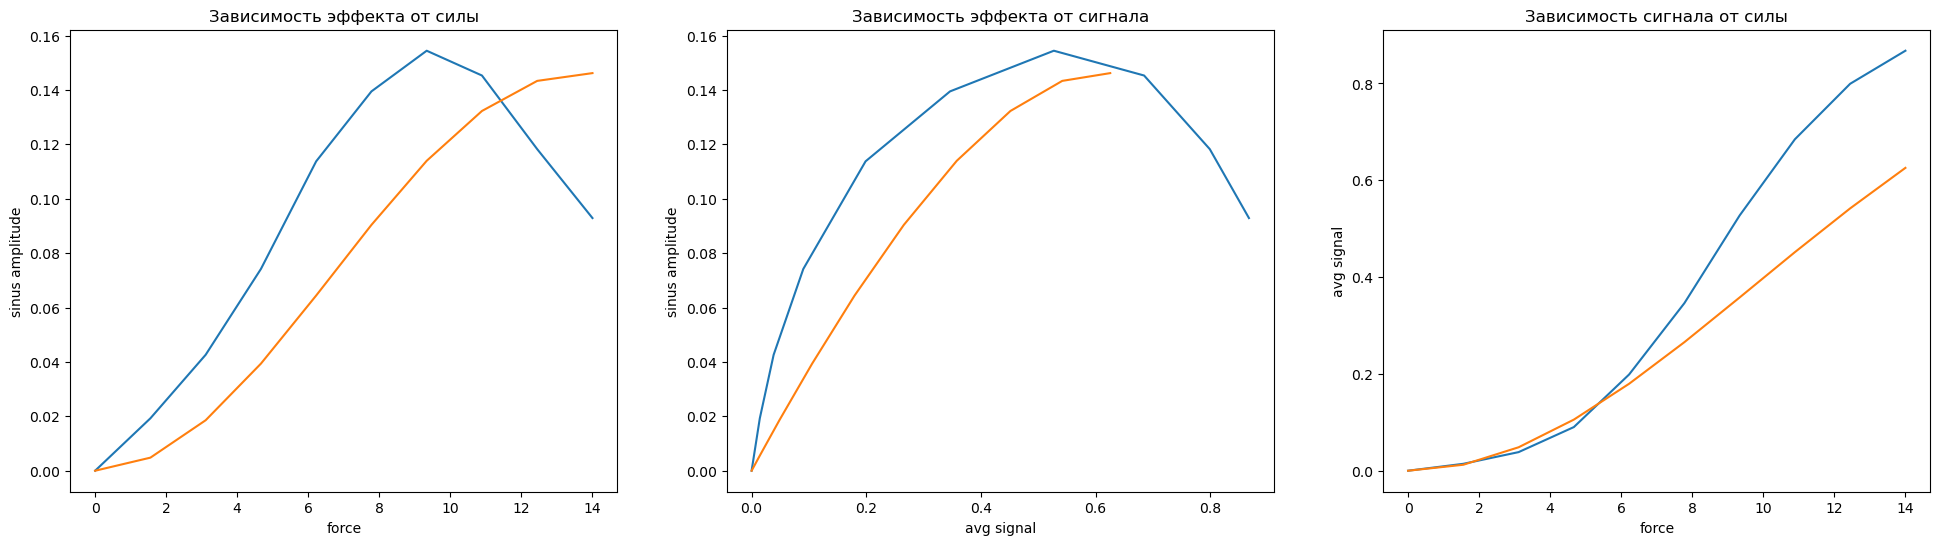

In [ ]:
forces, avg_signal, sinus_ampl = simulate_curves([[res.x[0], 0], res.x[1:3]])
plt.figure(figsize=(24, 6))

plt.subplot(1, 3, 1)
plt.plot(exp_forces, exp_sinus_ampl)
plt.plot(forces, sinus_ampl)
plt.xlabel("force")
plt.ylabel("sinus amplitude")
plt.title("Зависимость эффекта от силы")

plt.subplot(1, 3, 2)
plt.plot(exp_avg_signal, exp_sinus_ampl)
plt.plot(avg_signal, sinus_ampl)
plt.xlabel("avg signal")
plt.ylabel("sinus amplitude")
plt.title("Зависимость эффекта от сигнала")

plt.subplot(1, 3, 3)
plt.plot(exp_forces, exp_avg_signal)
plt.plot(forces, avg_signal)
plt.xlabel("force")
plt.ylabel("avg signal")
plt.title("Зависимость сигнала от силы")


# Запускаю оптимизацию на GPU

#### Объявляю функции для оптимизации

In [40]:
N = 10

In [41]:
indent = 40

def gen_point_pres(x):
    d = 1
    point_pres = np.zeros((111, d), dtype=np.float32)
    point_pres[x, d//2] = 1*0.04 * 40       # firstly for gaus blur. Secondly for force equality
    return point_pres
point_pres = gen_point_pres(35)

dataset_point_presses = np.zeros((point_pres.shape[0]-2*indent,) + point_pres.shape, dtype=np.float32)
for i in range(indent, point_pres.shape[0]-indent):
    dataset_point_presses[i-indent] = gen_point_pres(i)
dataset_X = np.linspace(0, dataset_point_presses.shape[0]*0.1, dataset_point_presses.shape[0], endpoint=False)

In [42]:
exp_forces = np.linspace(0, 14, N)
exp_avg_signal = np.zeros_like(exp_forces)
exp_sinus_ampl = np.zeros_like(exp_forces)

In [43]:

def sinus_func(x, w, phi, A, C):
    return np.sin(x*w + phi)*A + C

from scipy.optimize import curve_fit

sinus_range = [10, 23]
for j, tenso_target in enumerate(exp_forces):
    log_pars_func = interplating_parser(tenso_target, subtracting_first=True)

    X = []
    Y = []
    Z = []
    for point_res in filtered_points:
        # xy = point_res['target_coordinate']
        xy = point_res['relative_coordinate']
        if xy[0] < sinus_range[0] or xy[0] > sinus_range[1]:
            continue
        X.append(xy[0])
        Y.append(xy[1])
        Z.append(max(0, min(log_pars_func(point_res), 1)))
        
    popt, pcov = curve_fit(sinus_func, np.array(X), np.array(Z), p0=[2*np.pi/(7/3), 2.5, 0.1, np.mean(Z)])
    exp_sinus_ampl[j] = np.abs(popt[2])
    exp_avg_signal[j] = popt[3]

    
#     plt.plot(X, Z, 'o', ms=2, linewidth=0.5, label=f'F = {tenso_target:.3f}, T={2*np.pi/popt[0]:.3f} мм')  #  +- {np.sqrt(pcov[0, 0]):.3f}
#     t_x = np.linspace(min(X), max(X), 150)
#     plt.plot(t_x, sinus_func(t_x, *popt))
#     plt.xlabel('x, мм')
    
# plt.legend(fontsize=5)

#### Объявление функции симуляции

In [44]:
def simulate_curves(matrix):

    config['env']['bimodal']['intermode_matrix'] = matrix
    
    simb = tbsl.FiberSimulator(config)

    N = len(exp_forces)

    forces = np.linspace(0, 14, N)
    avg_signal = np.zeros_like(forces)
    sinus_ampl = np.zeros_like(forces)


    def sinus_func(x, w, phi, A, C):
        return np.sin(x*w + phi)*A + C

    from scipy.optimize import curve_fit

    for j, ample in enumerate(forces):
        result_numbers = simb.fiber_real_sim(dataset_point_presses*ample)
        sinus = result_numbers[:, 0, result_numbers.shape[-1]//2].numpy()
        
        popt, pcov = curve_fit(sinus_func, dataset_X, sinus, p0=[2*np.pi/(7/3), 2.5, 0.1, np.mean(sinus)])
        sinus_ampl[j] = np.abs(popt[2])
        avg_signal[j] = popt[3]
    
    return forces, avg_signal, sinus_ampl


In [45]:
forces, avg_signal, sinus_ampl = simulate_curves([[0.5, 0], 
                                                [0.5, 0.5]])

Text(0.5, 1.0, 'Зависимость сигнала от силы')

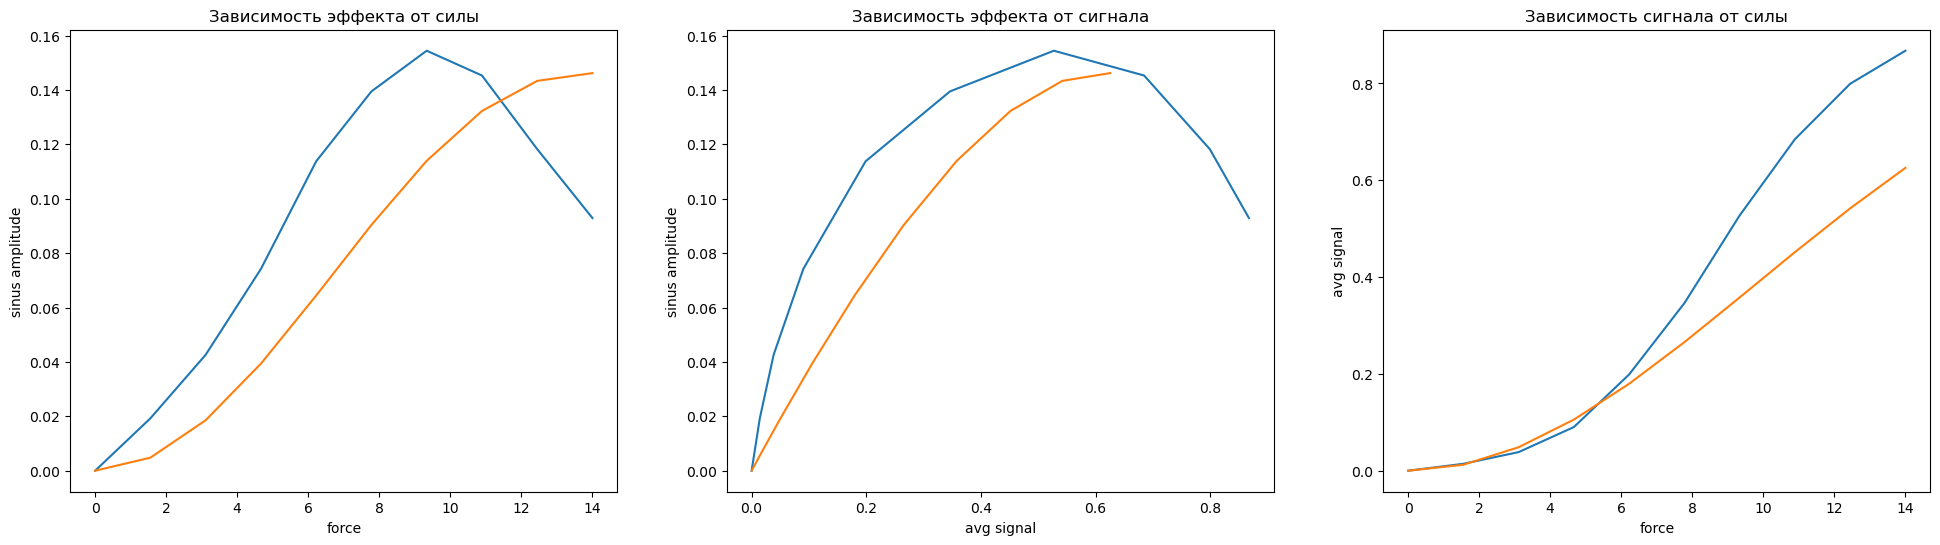

In [46]:
plt.figure(figsize=(24, 6))

plt.subplot(1, 3, 1)
plt.plot(exp_forces, exp_sinus_ampl)
plt.plot(forces, sinus_ampl)
plt.xlabel("force")
plt.ylabel("sinus amplitude")
plt.title("Зависимость эффекта от силы")

plt.subplot(1, 3, 2)
plt.plot(exp_avg_signal, exp_sinus_ampl)
plt.plot(avg_signal, sinus_ampl)
plt.xlabel("avg signal")
plt.ylabel("sinus amplitude")
plt.title("Зависимость эффекта от сигнала")

plt.subplot(1, 3, 3)
plt.plot(exp_forces, exp_avg_signal)
plt.plot(forces, avg_signal)
plt.xlabel("force")
plt.ylabel("avg signal")
plt.title("Зависимость сигнала от силы")


#### Запускаю на этом shgo оптимизатор.

In [47]:
def dist_func(params):
    forces, avg_signal, sinus_ampl = simulate_curves([[params[0], params[1]], 
                                                [params[2], params[3]]])
    dist = np.mean(np.square(avg_signal-exp_avg_signal)) + np.mean(np.square(sinus_ampl-exp_sinus_ampl))
    return dist

In [48]:
dist_func([0.5, 0.5, 0.5, 0.5])

0.027880719234064384

In [49]:
from scipy import optimize

res = optimize.shgo(dist_func, [(0, 4.0), (-2.0, 3.0), (-2.0, 3.0), (0.0, 4.0)])
res

     fun: 0.027081698176029026
    funl: array([0.0270817, 0.0341158])
 message: 'Optimization terminated successfully.'
    nfev: 27
     nit: 2
   nlfev: 10
   nlhev: 0
   nljev: 2
 success: True
       x: array([ 0.,  3., -2.,  4.])
      xl: array([[ 0.,  3., -2.,  4.],
       [ 0., -2.,  3.,  4.]])

Text(0.5, 1.0, 'Зависимость сигнала от силы')

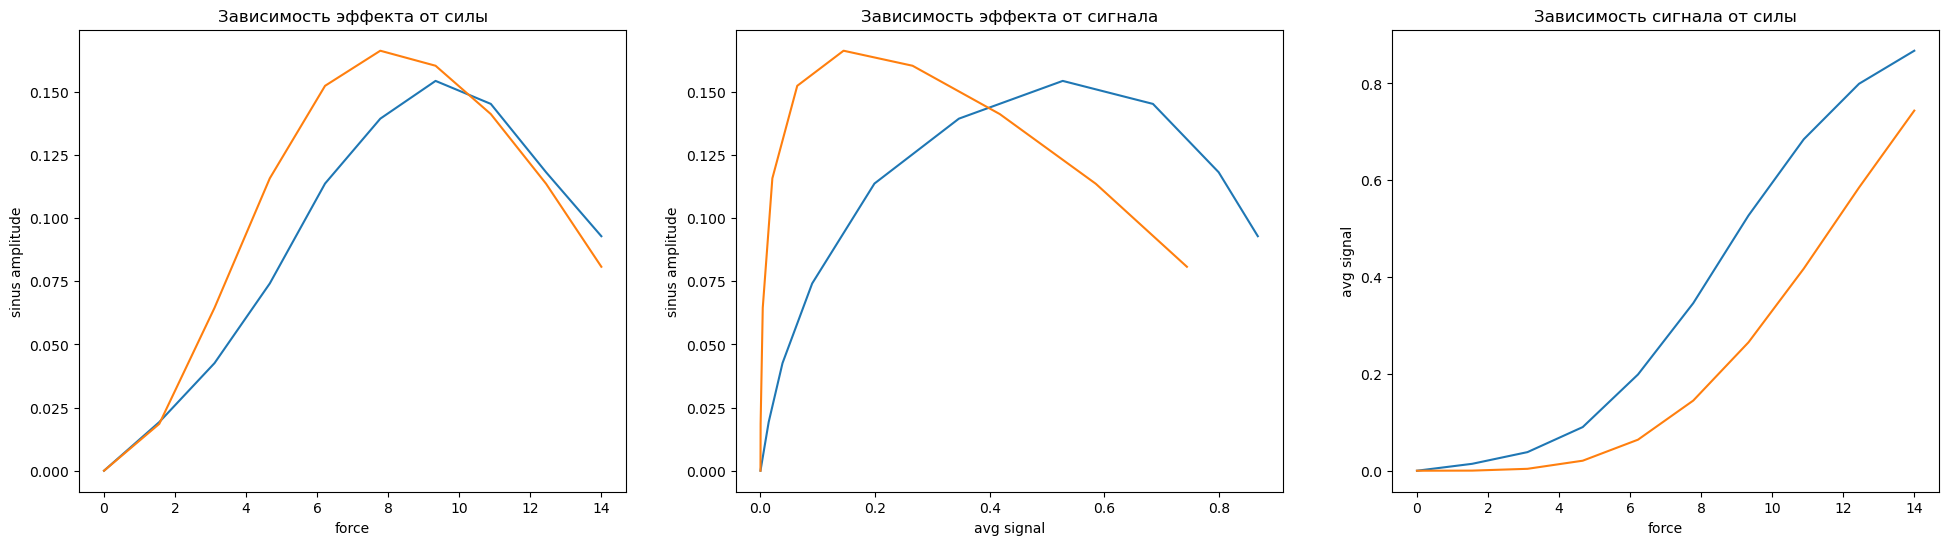

In [50]:
forces, avg_signal, sinus_ampl = simulate_curves([res.x[0:2], res.x[2:4]])
plt.figure(figsize=(24, 6))

plt.subplot(1, 3, 1)
plt.plot(exp_forces, exp_sinus_ampl)
plt.plot(forces, sinus_ampl)
plt.xlabel("force")
plt.ylabel("sinus amplitude")
plt.title("Зависимость эффекта от силы")

plt.subplot(1, 3, 2)
plt.plot(exp_avg_signal, exp_sinus_ampl)
plt.plot(avg_signal, sinus_ampl)
plt.xlabel("avg signal")
plt.ylabel("sinus amplitude")
plt.title("Зависимость эффекта от сигнала")

plt.subplot(1, 3, 3)
plt.plot(exp_forces, exp_avg_signal)
plt.plot(forces, avg_signal)
plt.xlabel("force")
plt.ylabel("avg signal")
plt.title("Зависимость сигнала от силы")


In [51]:
from scipy import optimize

res = optimize.shgo(dist_func, [(0, 1.0), (0.0, 0.0), (0.5, 1.0), (0.0, 1.0)])
res

     fun: 0.004806934524460312
 message: 'Failed to find a feasible minimizer point. Lowest sampling point = 0.004806934524460312'
    nfev: 17
     nit: 2
   nlfev: 0
   nlhev: 0
   nljev: 0
 success: False
       x: array([1., 0., 1., 1.])

Text(0.5, 1.0, 'Зависимость сигнала от силы')

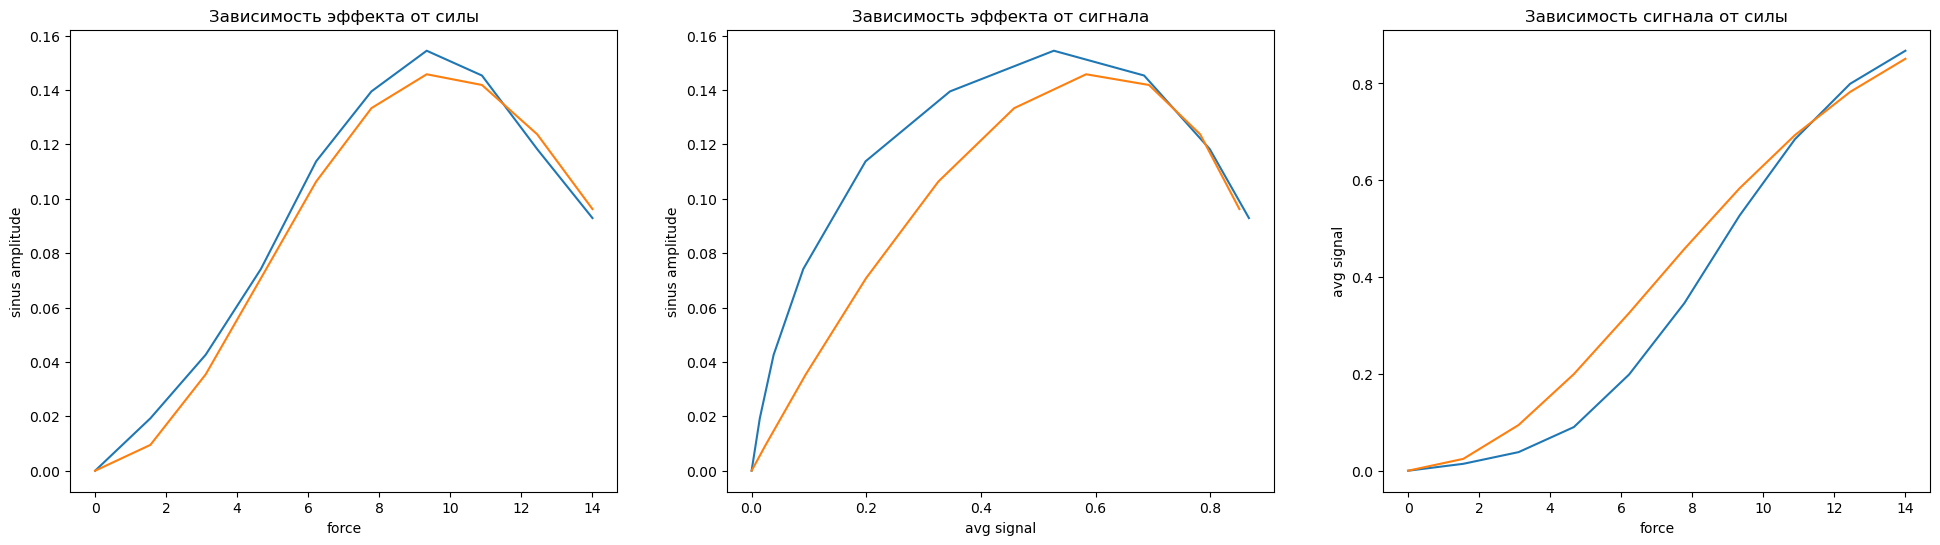

In [52]:
forces, avg_signal, sinus_ampl = simulate_curves([res.x[0:2], res.x[2:4]])
plt.figure(figsize=(24, 6))

plt.subplot(1, 3, 1)
plt.plot(exp_forces, exp_sinus_ampl)
plt.plot(forces, sinus_ampl)
plt.xlabel("force")
plt.ylabel("sinus amplitude")
plt.title("Зависимость эффекта от силы")

plt.subplot(1, 3, 2)
plt.plot(exp_avg_signal, exp_sinus_ampl)
plt.plot(avg_signal, sinus_ampl)
plt.xlabel("avg signal")
plt.ylabel("sinus amplitude")
plt.title("Зависимость эффекта от сигнала")

plt.subplot(1, 3, 3)
plt.plot(exp_forces, exp_avg_signal)
plt.plot(forces, avg_signal)
plt.xlabel("force")
plt.ylabel("avg signal")
plt.title("Зависимость сигнала от силы")


In [53]:
from scipy import optimize

res = optimize.shgo(dist_func, [(0, 1.5), (0.0, 1.1), (0.5, 1.1), (0.0, 1.6)])
res

     fun: 0.004527300739492848
    funl: array([0.0045273])
 message: 'Optimization terminated successfully.'
    nfev: 27
     nit: 2
   nlfev: 10
   nlhev: 0
   nljev: 2
 success: True
       x: array([0.8810405 , 0.55      , 0.83207348, 0.80189152])
      xl: array([[0.8810405 , 0.55      , 0.83207348, 0.80189152]])

Text(0.5, 1.0, 'Зависимость сигнала от силы')

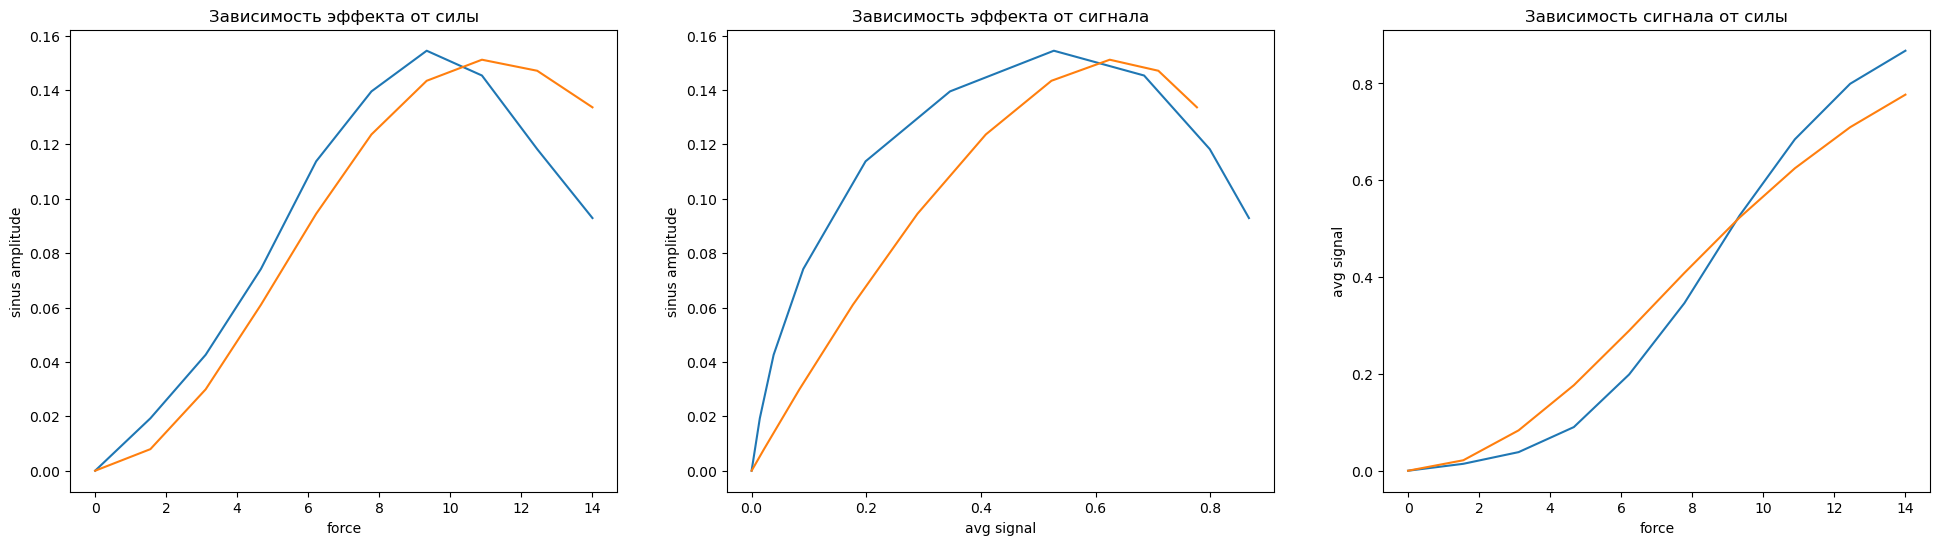

In [54]:
forces, avg_signal, sinus_ampl = simulate_curves([res.x[0:2], res.x[2:4]])
plt.figure(figsize=(24, 6))

plt.subplot(1, 3, 1)
plt.plot(exp_forces, exp_sinus_ampl)
plt.plot(forces, sinus_ampl)
plt.xlabel("force")
plt.ylabel("sinus amplitude")
plt.title("Зависимость эффекта от силы")

plt.subplot(1, 3, 2)
plt.plot(exp_avg_signal, exp_sinus_ampl)
plt.plot(avg_signal, sinus_ampl)
plt.xlabel("avg signal")
plt.ylabel("sinus amplitude")
plt.title("Зависимость эффекта от сигнала")

plt.subplot(1, 3, 3)
plt.plot(exp_forces, exp_avg_signal)
plt.plot(forces, avg_signal)
plt.xlabel("force")
plt.ylabel("avg signal")
plt.title("Зависимость сигнала от силы")


## Увеличиваю данные для оптимизации

#### Объявляю функции для оптимизации

In [66]:
N = 25

In [67]:
indent = 40

def gen_point_pres(x):
    d = 1
    point_pres = np.zeros((111, d), dtype=np.float32)
    point_pres[x, d//2] = 1*0.04 * 40       # firstly for gaus blur. Secondly for force equality
    return point_pres
point_pres = gen_point_pres(35)

dataset_point_presses = np.zeros((point_pres.shape[0]-2*indent,) + point_pres.shape, dtype=np.float32)
for i in range(indent, point_pres.shape[0]-indent):
    dataset_point_presses[i-indent] = gen_point_pres(i)
dataset_X = np.linspace(0, dataset_point_presses.shape[0]*0.1, dataset_point_presses.shape[0], endpoint=False)

In [74]:
exp_forces = np.linspace(0, 17, N)
exp_avg_signal = np.zeros_like(exp_forces)
exp_sinus_ampl = np.zeros_like(exp_forces)

In [75]:

def sinus_func(x, w, phi, A, C):
    return np.sin(x*w + phi)*A + C

from scipy.optimize import curve_fit

sinus_range = [10, 23]
for j, tenso_target in enumerate(exp_forces):
    log_pars_func = interplating_parser(tenso_target, subtracting_first=True)

    X = []
    Y = []
    Z = []
    for point_res in filtered_points:
        # xy = point_res['target_coordinate']
        xy = point_res['relative_coordinate']
        if xy[0] < sinus_range[0] or xy[0] > sinus_range[1]:
            continue
        X.append(xy[0])
        Y.append(xy[1])
        Z.append(max(0, min(log_pars_func(point_res), 1)))
        
    popt, pcov = curve_fit(sinus_func, np.array(X), np.array(Z), p0=[2*np.pi/(7/3), 2.5, 0.1, np.mean(Z)])
    exp_sinus_ampl[j] = np.abs(popt[2])
    exp_avg_signal[j] = popt[3]

    
#     plt.plot(X, Z, 'o', ms=2, linewidth=0.5, label=f'F = {tenso_target:.3f}, T={2*np.pi/popt[0]:.3f} мм')  #  +- {np.sqrt(pcov[0, 0]):.3f}
#     t_x = np.linspace(min(X), max(X), 150)
#     plt.plot(t_x, sinus_func(t_x, *popt))
#     plt.xlabel('x, мм')
    
# plt.legend(fontsize=5)

In [76]:
def simulate_curves(matrix):

    config['env']['bimodal']['intermode_matrix'] = matrix
    
    simb = tbsl.FiberSimulator(config)

    N = len(exp_forces)

    forces = exp_forces
    avg_signal = np.zeros_like(forces)
    sinus_ampl = np.zeros_like(forces)


    def sinus_func(x, w, phi, A, C):
        return np.sin(x*w + phi)*A + C

    from scipy.optimize import curve_fit

    for j, ample in enumerate(forces):
        result_numbers = simb.fiber_real_sim(dataset_point_presses*ample)
        sinus = result_numbers[:, 0, result_numbers.shape[-1]//2].numpy()
        
        popt, pcov = curve_fit(sinus_func, dataset_X, sinus, p0=[2*np.pi/(7/3), 2.5, 0.1, np.mean(sinus)])
        sinus_ampl[j] = np.abs(popt[2])
        avg_signal[j] = popt[3]
    
    return forces, avg_signal, sinus_ampl


In [77]:
forces, avg_signal, sinus_ampl = simulate_curves([[0.5, 0], 
                                                [0.5, 0.5]])

Text(0.5, 1.0, 'Зависимость сигнала от силы')

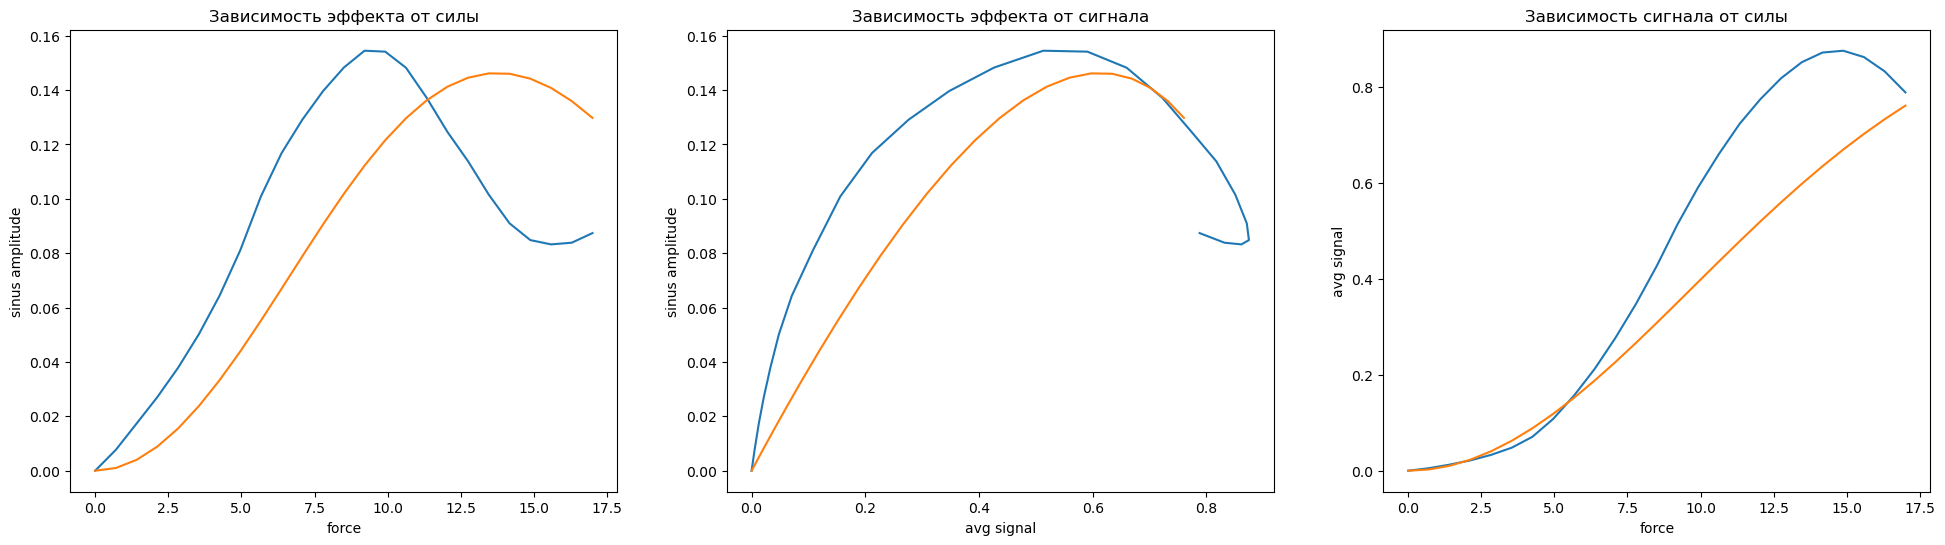

In [78]:
plt.figure(figsize=(24, 6))

plt.subplot(1, 3, 1)
plt.plot(exp_forces, exp_sinus_ampl)
plt.plot(forces, sinus_ampl)
plt.xlabel("force")
plt.ylabel("sinus amplitude")
plt.title("Зависимость эффекта от силы")

plt.subplot(1, 3, 2)
plt.plot(exp_avg_signal, exp_sinus_ampl)
plt.plot(avg_signal, sinus_ampl)
plt.xlabel("avg signal")
plt.ylabel("sinus amplitude")
plt.title("Зависимость эффекта от сигнала")

plt.subplot(1, 3, 3)
plt.plot(exp_forces, exp_avg_signal)
plt.plot(forces, avg_signal)
plt.xlabel("force")
plt.ylabel("avg signal")
plt.title("Зависимость сигнала от силы")


#### Запускаю на этом shgo оптимизатор.

In [79]:
from scipy import optimize

res = optimize.shgo(dist_func, [(0, 1.0), (0.0, 0.0), (0.5, 1.0), (0.0, 1.0)])
res

     fun: 0.005576300684392851
 message: 'Failed to find a feasible minimizer point. Lowest sampling point = 0.005576300684392851'
    nfev: 17
     nit: 2
   nlfev: 0
   nlhev: 0
   nljev: 0
 success: False
       x: array([1., 0., 1., 1.])

Text(0.5, 1.0, 'Зависимость сигнала от силы')

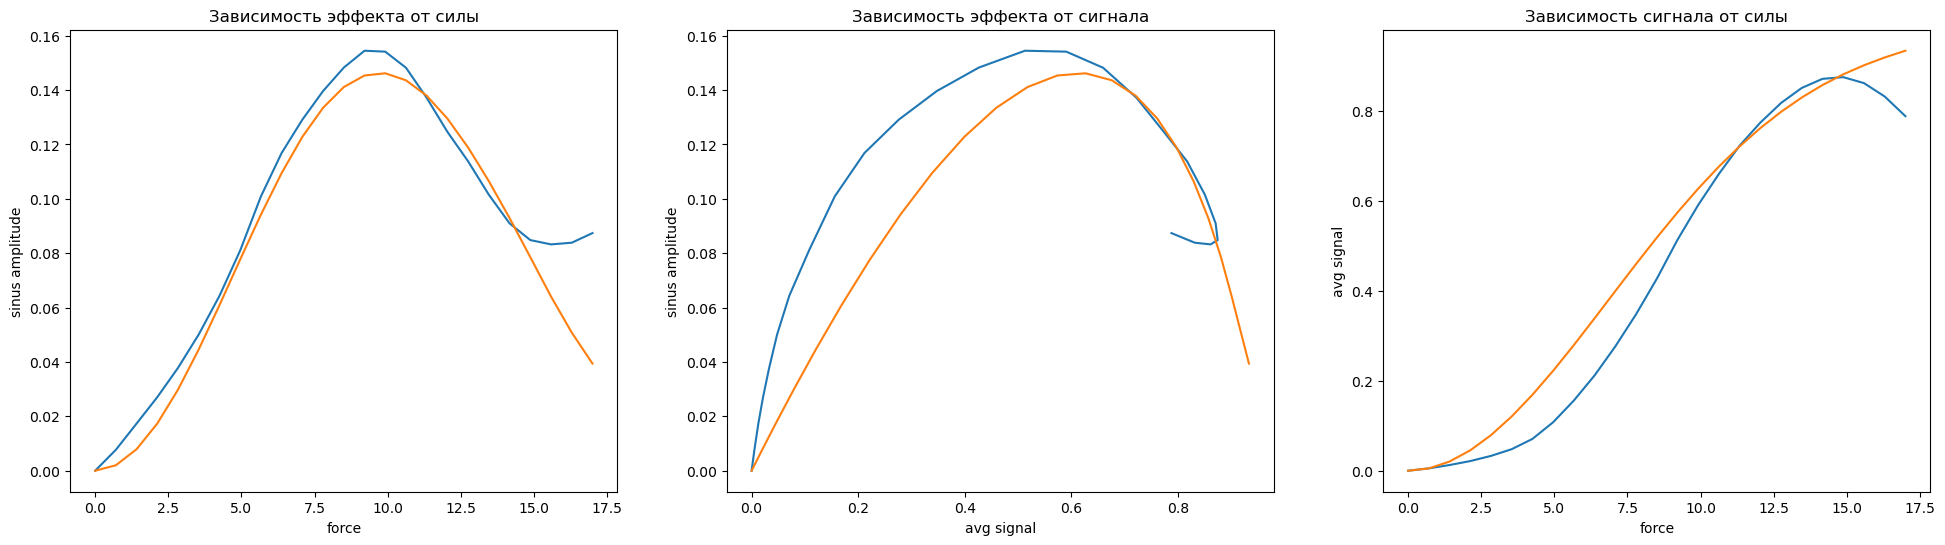

In [80]:
forces, avg_signal, sinus_ampl = simulate_curves([res.x[0:2], res.x[2:4]])
plt.figure(figsize=(24, 6))

plt.subplot(1, 3, 1)
plt.plot(exp_forces, exp_sinus_ampl)
plt.plot(forces, sinus_ampl)
plt.xlabel("force")
plt.ylabel("sinus amplitude")
plt.title("Зависимость эффекта от силы")

plt.subplot(1, 3, 2)
plt.plot(exp_avg_signal, exp_sinus_ampl)
plt.plot(avg_signal, sinus_ampl)
plt.xlabel("avg signal")
plt.ylabel("sinus amplitude")
plt.title("Зависимость эффекта от сигнала")

plt.subplot(1, 3, 3)
plt.plot(exp_forces, exp_avg_signal)
plt.plot(forces, avg_signal)
plt.xlabel("force")
plt.ylabel("avg signal")
plt.title("Зависимость сигнала от силы")


In [81]:
from scipy import optimize

res = optimize.shgo(dist_func,  [(0, 1.5), (0.0, 1.1), (0.5, 1.1), (0.0, 1.6)])
res

     fun: 0.004513373905227769
    funl: array([0.00451337])
 message: 'Optimization terminated successfully.'
    nfev: 27
     nit: 2
   nlfev: 10
   nlhev: 0
   nljev: 2
 success: True
       x: array([0.84340791, 0.55      , 0.75359695, 0.78468875])
      xl: array([[0.84340791, 0.55      , 0.75359695, 0.78468875]])

Text(0.5, 1.0, 'Зависимость сигнала от силы')

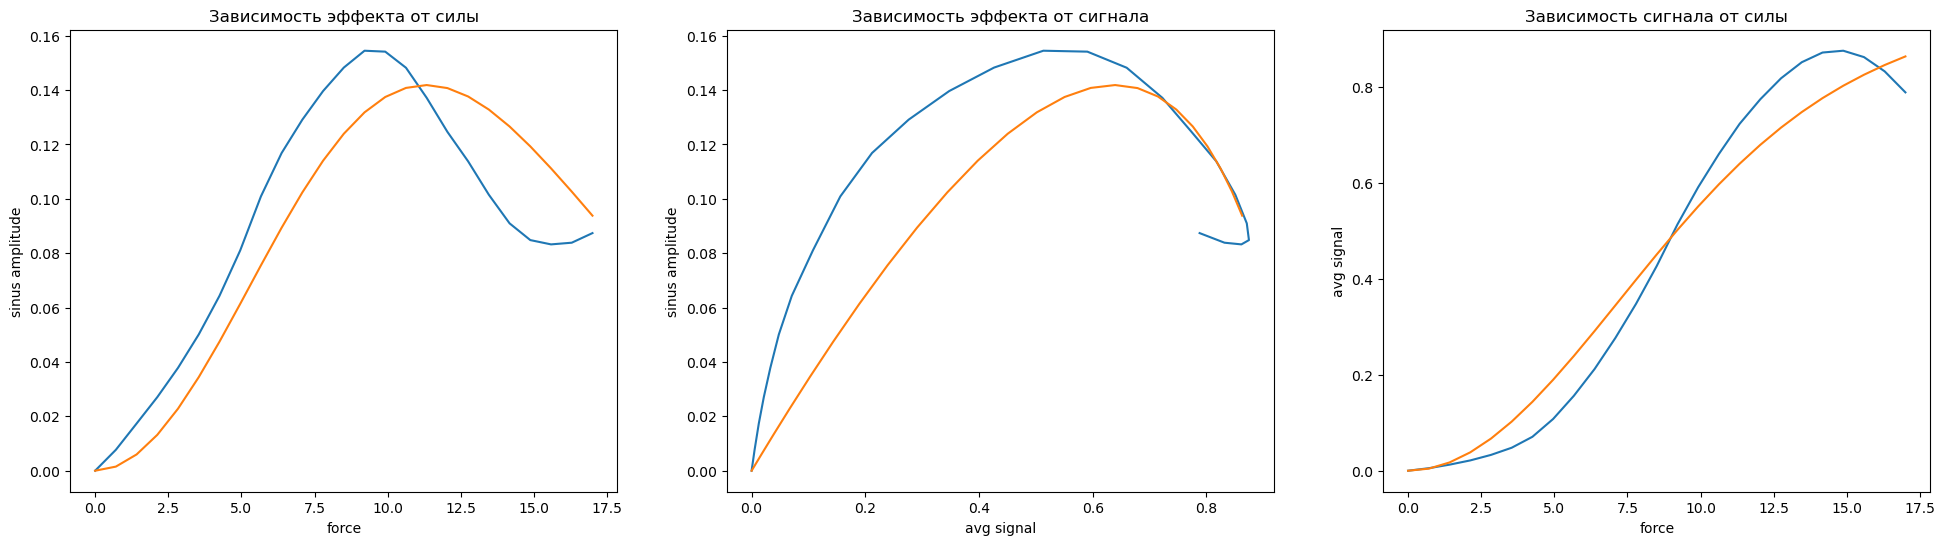

In [82]:
forces, avg_signal, sinus_ampl = simulate_curves([res.x[0:2], res.x[2:4]])
plt.figure(figsize=(24, 6))

plt.subplot(1, 3, 1)
plt.plot(exp_forces, exp_sinus_ampl)
plt.plot(forces, sinus_ampl)
plt.xlabel("force")
plt.ylabel("sinus amplitude")
plt.title("Зависимость эффекта от силы")

plt.subplot(1, 3, 2)
plt.plot(exp_avg_signal, exp_sinus_ampl)
plt.plot(avg_signal, sinus_ampl)
plt.xlabel("avg signal")
plt.ylabel("sinus amplitude")
plt.title("Зависимость эффекта от сигнала")

plt.subplot(1, 3, 3)
plt.plot(exp_forces, exp_avg_signal)
plt.plot(forces, avg_signal)
plt.xlabel("force")
plt.ylabel("avg signal")
plt.title("Зависимость сигнала от силы")
